In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing
import math

## Demand and Weather
Load generated Files from before:

In [2]:
brm = pd.read_csv("../resources/bremen.csv")
frb = pd.read_csv("../resources/freiburg.csv")

brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

Create functions to create dataframes nad plots

In [3]:
def create_data(drivenframe,weatherframe): #input weather and driven data from demand
    drivenframe["trip_duration"] = drivenframe["trip_duration"].apply(pd.Timedelta)
    combined = weatherframe.join(drivenframe["trip_duration"]) #join dataframes
    daily = combined.groupby("day").agg({"trip_duration":"sum","precipitation":"mean","temperature":"mean"}) #group and aggregate data
    daily["trip_duration_in_hours"] = daily["trip_duration"].map(lambda x: (x.total_seconds() / 60 / 60))# calc trip duration in hours
    daily = daily.reset_index() #reset index
    daily["day"] = pd.to_datetime(daily["day"])
    daily["week"] = daily["day"].map(lambda x: (x.strftime("%W"))) #make 2 new colums so we can aggregate weekly
    daily["year"] = daily["day"].map(lambda x: (x.strftime("%Y")))
    
    weekly = daily.groupby(["year","week"]).agg({"trip_duration_in_hours":"sum","precipitation":"sum","temperature":"mean"})#aggergate data weekly
    weekly = weekly.reset_index() 
    return [daily,weekly]

def create_plot(frame,column):
    values = frame[["precipitation","temperature","trip_duration_in_hours"]].values# get values from frame
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) #define scaler(normalize data)...
    scaled = scaler.fit_transform(values)
    demand = pd.DataFrame(scaled)
    plt.figure(figsize=(16,8))
    plt.plot(column,demand[0],label = "precipitation |"
         + " min: " + str(frame["precipitation"].min()) 
         + " max: " + str(frame["precipitation"].max()))
    plt.plot(column,demand[1],label = "temperature |"
         + " min: " + str(math.floor(frame["temperature"].min())) 
         + " max: " + str(math.floor(frame["temperature"].max())))
    plt.plot(column,demand[2],label = "trip in hours |"
         + " min: " + str(math.floor(frame["trip_duration_in_hours"].min())) 
         + " max: " + str(math.floor(frame["trip_duration_in_hours"].max())))
    plt.ylabel('normalized value')
    plt.title('demand overview daily')
    plt.legend()
    plt.show()
    
def increment_week(frame): #add 53 to weeks in 2020 so we can plot it with week as counter 
    for i in frame.index:
        #chech for the correct year and if the function has been already applied
        if((frame.at[i,"year"]== "2020") and (int(frame.at[i,"week"]) < 52)):
            frame.at[i,"week"] = str(int(frame.at[i,"week"]) + 53)

In [4]:
brm_daily = create_data(brm_hourly_driven,brm_hourly_weather)[0]
brm_weekly = create_data(brm_hourly_driven,brm_hourly_weather)[1]

frb_daily = create_data(frb_hourly_driven,frb_hourly_weather)[0]
frb_weekly = create_data(frb_hourly_driven,frb_hourly_weather)[1]

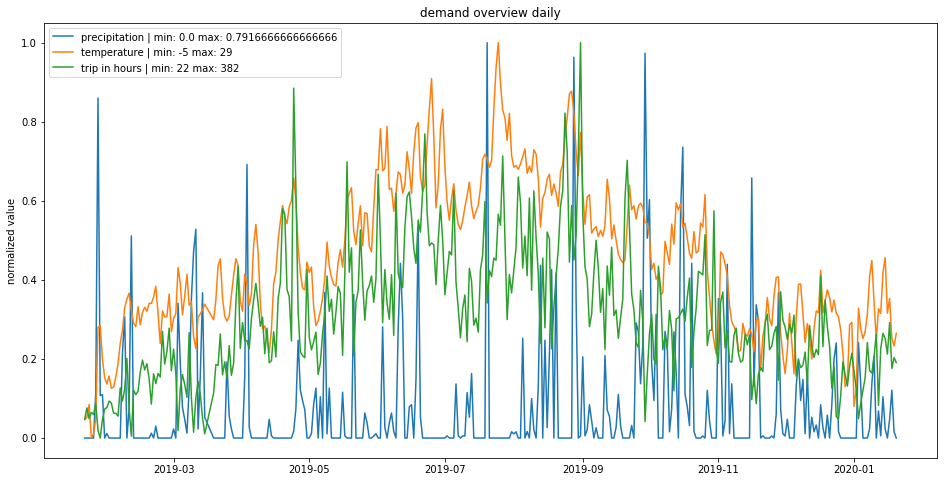

In [5]:
create_plot(brm_daily,brm_daily["day"])

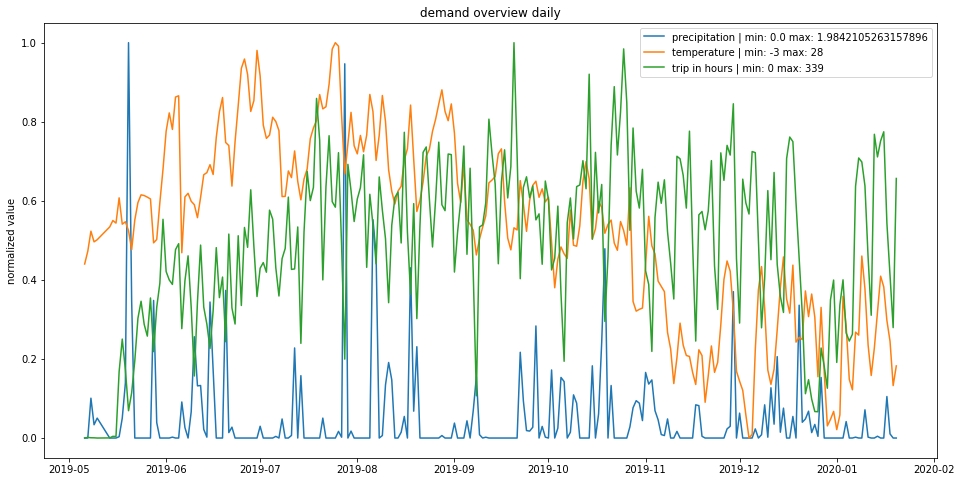

In [6]:
create_plot(frb_daily,frb_daily["day"])

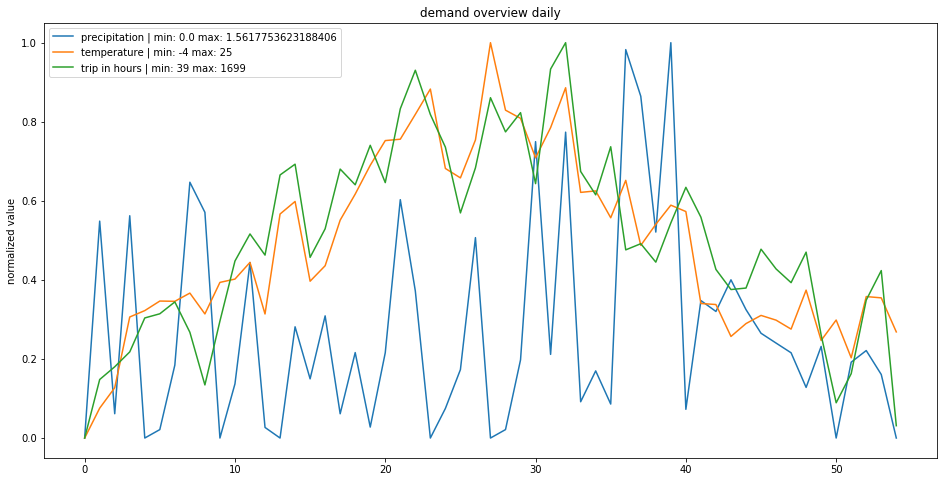

In [7]:
create_plot(brm_weekly,brm_weekly.index)

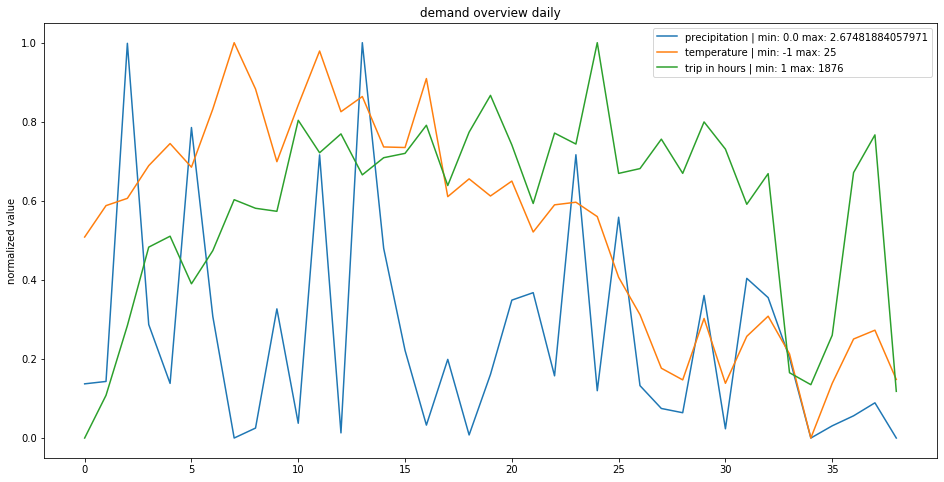

In [8]:
create_plot(frb_weekly,frb_weekly.index)

In [ ]:
increment_week(brm_weekly)
increment_week(frb_weekly)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(brm_weekly["week"],brm_weekly["trip_duration_in_hours"],label="bremen")
plt.plot(frb_weekly["week"],frb_weekly["trip_duration_in_hours"],label="freiburg")
plt.xlabel('week')
plt.ylabel('trip in hours')
plt.title('comparison of demand Bremen & Freiburg')
plt.legend()
plt.show()

In [ ]:
print("Number of Bikes: " + str(len(brm["b_number"].unique())) + " Bremen" + " vs. " + str(len(frb["b_number"].unique())) + " Freiburg")

As we can see the data for Freiburg started at 6.5.2019 which is week 18 in our plot.
After that we have a strong increase and in total more triptime than bremen even if the population is much lower in Freiburg (230k vs. 550k) altough the number of bikes is nearly the same (as seen above). In the Winterholidays there are clearly less bikes users in both cities. The high difference in triptime at week 38+ could relate with the higher temperatures in Freiburg during that time.

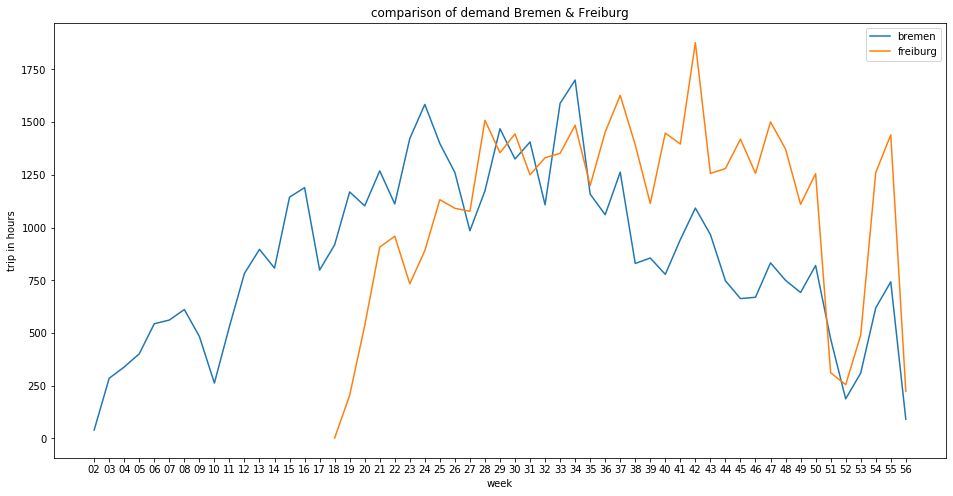

In [33]:
plt.figure(figsize=(16,8))
plt.plot(brm_weekly["week"],brm_weekly["trip_duration_in_hours"],label="bremen")
plt.plot(frb_weekly["week"],frb_weekly["trip_duration_in_hours"],label="freiburg")
plt.xlabel('week')
plt.ylabel('trip in hours')
plt.title('comparison of demand Bremen & Freiburg')
plt.legend()
plt.show()

In [45]:
print("Number of Bikes: " + str(len(brm["b_number"].unique())) + " Bremen" + " vs. " + str(len(frb["b_number"].unique())) + " Freiburg")

Number of Bikes: 441 Bremen vs. 435 Freiburg


As we can see the data for Freiburg started at 6.5.2019 which is week 18 in our plot.
After that we have a strong increase and in total more triptime than bremen even if the population is much lower in Freiburg (230k vs. 550k) altough the number of bikes is nearly the same (as seen above). In the Winterholidays there are clearly less bikes users in both cities. The high difference in triptime at week 38+ could relate with the higher temperatures in Freiburg during that time.